### 代码5-1 先来瞅瞅多简单就干了一个大活
- Huggingface这个包基本上就是调用即可，开箱即用的过程

In [4]:
## import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline#用人家设计好的流程完成一些简单的任务
classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

### 基本流程概述分析

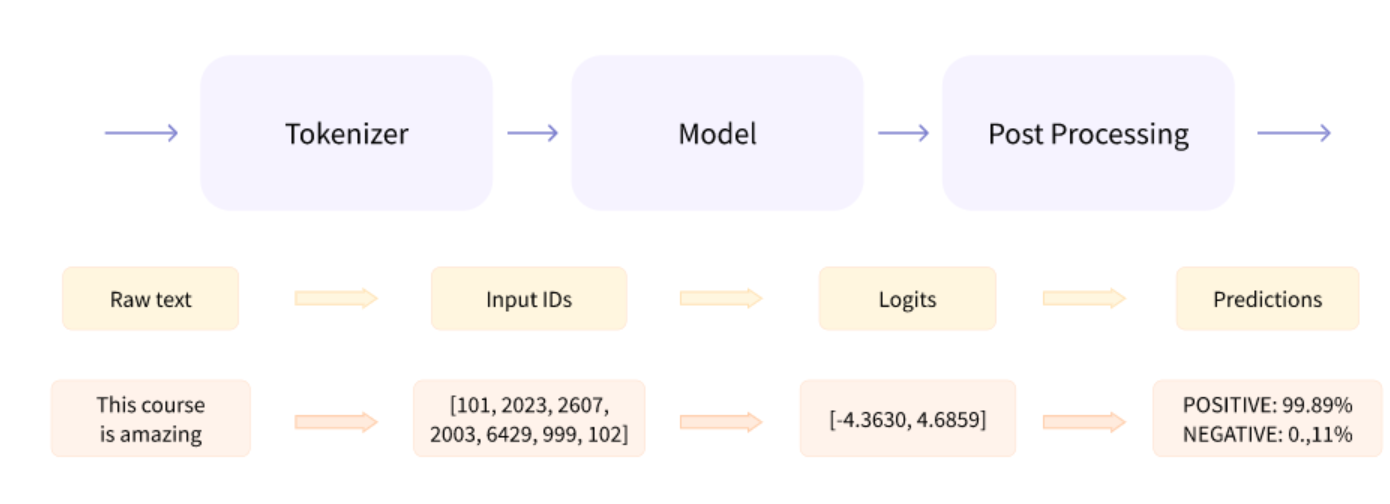

### Tokenizer要做的事：
- 分词，分字以及特殊字符（起始，终止，间隔，分类等特殊字符可以自己设计的）
- 对每一个token映射得到一个ID（每个词都会对应一个唯一的ID）
- 还有一些辅助信息也可以得到，比如当前词属于哪个句子（还有一些MASK，表示是否事原来的词还是特殊字符等）

### 代码5-2 自动加载模型

In [5]:
from transformers import AutoTokenizer#自动判断

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"#根据这个模型所对应的来加载
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### 代码5-3 分词效果

In [6]:
raw_inputs = [
    "I've been waiting for a this course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[ 101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 2023, 2607, 2026, 2878,
         2166, 1012,  102],
        [ 101, 1045, 5223, 2023, 2061, 2172,  999,  102,    0,    0,    0,    0,
            0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


### 代码5-4 加载预训练模型

In [7]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

### 代码5-5 打印输出

In [9]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 15, 768])


### 模型基本逻辑

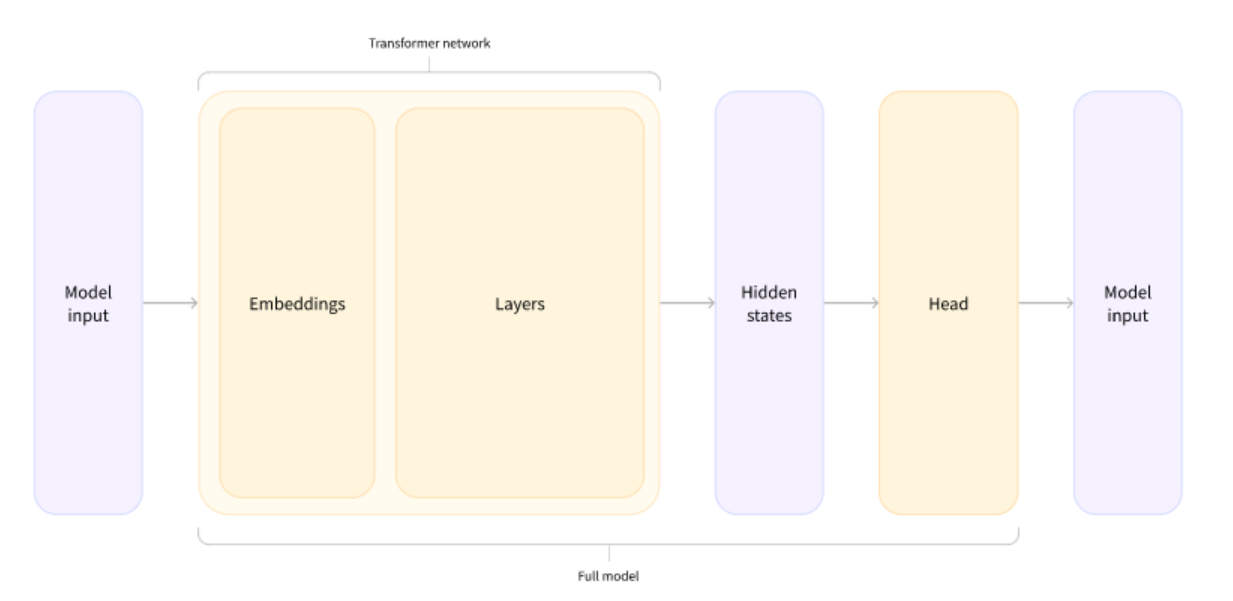

### 代码5-6 加载模型

In [10]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([2, 2])


In [11]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

### 代码5-7 输出

In [12]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[1.5446e-02, 9.8455e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


### 代码5-8 保存模型

In [13]:
model.save_pretrained("./")

### 代码5-9 加载数据集

In [1]:
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset#https://github.com/huggingface/datasets

raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

Found cached dataset glue (C:/Users/86136/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

### 图5-9 数据格式

In [4]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[100]

{'sentence1': 'The Nasdaq composite index inched up 1.28 , or 0.1 percent , to 1,766.60 , following a weekly win of 3.7 percent .',
 'sentence2': 'The technology-laced Nasdaq Composite Index .IXIC was off 24.44 points , or 1.39 percent , at 1,739.87 .',
 'label': 0,
 'idx': 114}

In [3]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

### 使用AutoTokenizer来处理数据

### 代码5-10 加载预训练模型

In [6]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

### 代码5-11 分词

In [7]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

### 代码5-12 自定义分词和数据集

In [8]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

### 代码5-13 DataLoader

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 图5-11 训练参数

In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")
training_args

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignor

### 代码5-14 模型加载

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### 代码5-15 开始训练

In [15]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

### 代码5-16 输出

In [16]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(408, 2) (408,)


### 训练过程中也可以指定好评估方法
#### 代码5-18

In [17]:
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [18]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
trainer.train()